In [9]:
import tensorflow as tf
import os
import sys
import collections

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)
from rl import action_learner, action_learner_search, value_estimator
import progress_learner
import config
import project
# Need to add this import to load class
from project import Project
from importlib import reload
from rl import block_movement_env
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting

reload(config)
c = config.Config()
c.no_of_loops = 1
# c.constraint_sigma = 0
reload(block_movement_env)
# reload(value_estimator)
reload(action_learner_search)
reload(progress_learner)
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

sess =  tf.Session()

with tf.variable_scope("search") as scope:
    policy_estimator = action_learner_search.PolicyEstimator(c)

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load('../' + p_name)

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training=False, name = projects[project_name].name, config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, '../progress_' + project_name + '.mod')

Load for action type = SlideToward
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
Load for action type = SlideAway
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
Load for action type = SlideNext
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
Load for action type = SlidePast
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.

In [13]:
c.progress_threshold=0.92
reload(action_learner_search)
action_lns = {}
for project_name in action_types:
    action_lns[project_name] = action_learner_search.ActionLearner_Search(c, projects[project_name], progress_estimators[project_name], session = sess)

..\experiments\human_evaluation_2d\SlideToward\
action_level = 0
exploration_index = 0
[(0, 0.7472112774848938), (0, 0.72180038690567017), (0, 0.72102051973342896), (0, 0.70660078525543213), (0, 0.69358277320861816), (0, 0.67942118644714355), (0, 0.6533164381980896), (0, 0.65310209989547729), (0, 0.63980388641357422)]
action_level = 1
exploration_index = 0
exploration_index = 1
exploration_index = 2
exploration_index = 3
exploration_index = 4
exploration_index = 5
exploration_index = 6
exploration_index = 7
exploration_index = 8
[(7, 0.89304351806640625), (2, 0.84092086553573608), (0, 0.82869511842727661), (4, 0.82673436403274536), (4, 0.82634449005126953), (2, 0.80009299516677856), (2, 0.79548048973083496), (0, 0.79483675956726074), (4, 0.77348977327346802)]
action_level = 2
exploration_index = 0
exploration_index = 1
exploration_index = 2
exploration_index = 3
exploration_index = 4
exploration_index = 5
exploration_index = 6
exploration_index = 7
exploration_index = 8
[(2, 0.92760968

KeyboardInterrupt: 

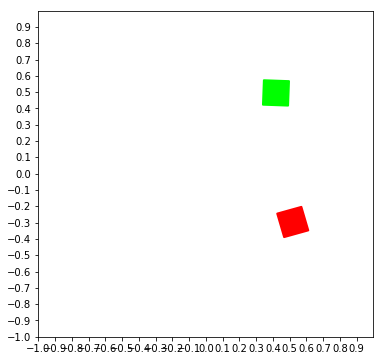

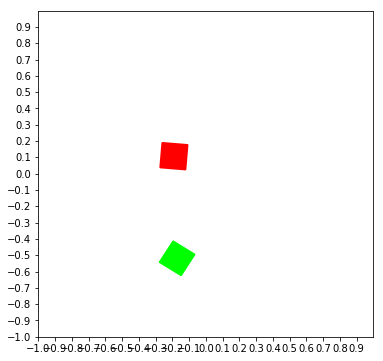

In [14]:
for project_name in action_types:
    prefix = "..\\experiments\\human_evaluation_2d\\" + project_name + "\\"
    print ("============")
    print (prefix)
    al = action_lns[project_name]
    for n in range(2):
        al.env.reset()
        explorations = al.learn_one_setup(verbose = True)
        explorations[0].save(prefix + str(n) + ".dat")
        explorations[0].save_visualization_to_file(prefix + str(n) + ".mp4")

In [15]:
feedback = "..\\experiments\\human_evaluation_2d\\slidearound.txt"

In [28]:
with open(feedback, 'r') as fh:
    wrong_demonstration_indices = []
    for line in fh:
        values = [int(v) for v in line.split()]
        index = values[0]
        average_score = np.mean(values[1:])
        if average_score <= 2.5:
            wrong_demonstration_indices.append(index)

print (len(wrong_demonstration_indices))
print (wrong_demonstration_indices)

19
[0, 2, 3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 21, 23, 24, 25, 27, 28, 29]


In [29]:
p = progress_estimators["SlideAround"]

In [34]:
reload(block_movement_env)
import pickle

In [32]:
prefix = os.path.join( "..", "experiments", "human_evaluation_2d" , "SlideAround")

In [46]:
for index in wrong_demonstration_indices:
    stored_config_file = os.path.join(prefix, str(index) + ".dat")
    with open(stored_config_file, 'rb') as fh:
        # need this encoding 
        stored_config = pickle.load(fh, encoding='latin-1')
        print (stored_config)

{'start_config': [Cube : [-0.01572524 -0.10102905  0.30911663], Cube : [ 0.19961559  0.49010506  1.44659077]], 'action_storage': [[0, [-0.01572524 -0.10102905  0.30911663] - 0.075, [-0.46145262  0.33233556  0.14982787] - 0.075, array([-0.43916625,  0.31066733,  0.15779231, -0.46145262,  0.33233556,
        0.14982787,  0.19961559,  0.49010506,  1.44659077,  0.19961559,
        0.49010506,  1.44659077]), 0.66035455, True, array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32)], [0, [-0.46145262  0.33233556  0.14982787] - 0.075, [ 0.83144515  0.24279438  0.17549452] - 0.075, array([ 0.73579087,  0.24941903,  0.17359559,  0.83144515,  0.24279438,
        0.17549452,  0.19961559,  0.49010506,  1.44659077,  0.19961559,
        0.49010506,  1.44659077]), 0.89616138, True, array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32)], [0, [ 0.83144515  0.24279438  0.17549452] - 0.075, [ 0.83144515  0.24279438  0.17549452] - 0.075, array([ 0.73579087

UnpicklingError: the STRING opcode argument must be quoted